In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
from tqdm import tqdm
import random
from collections import Counter
import pickle

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Configuración del Proyecto

In [12]:
# Rutas del proyecto
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_PATH = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DATA_PATH = PROJECT_ROOT / 'data' / 'processed'
RESULTS_PATH = PROJECT_ROOT / 'results' / 'figures'

# Crear directorios si no existen
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Constantes
IMG_SIZE = (224, 224)
RANDOM_SEED = 1214

# Reproducibilidad
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Proyecto: {PROJECT_ROOT}")
print(f"Datos: {DATA_PATH}")
print(f"Resultados: {RESULTS_PATH}")

Proyecto: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia
Datos: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\data\raw
Resultados: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\results\figures


## 2. Carga y Análisis del Dataset

In [13]:
def load_dataset_info(data_path):
    """Carga información del dataset."""
    dataset_info = {
        'train': {'NORMAL': [], 'PNEUMONIA': []},
        'test': {'NORMAL': [], 'PNEUMONIA': []},
        'val': {'NORMAL': [], 'PNEUMONIA': []}
    }
    
    chest_xray_path = data_path / 'chest_xray'
    
    if not chest_xray_path.exists():
        print(f"No se encontró el dataset en {chest_xray_path}")
        return None
    
    for split in ['train', 'test', 'val']:
        split_path = chest_xray_path / split
        if split_path.exists():
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = split_path / class_name
                if class_path.exists():
                    images = list(class_path.glob('*.jpeg')) + \
                            list(class_path.glob('*.jpg')) + \
                            list(class_path.glob('*.png'))
                    dataset_info[split][class_name] = images
    
    return dataset_info

dataset_info = load_dataset_info(DATA_PATH)

In [14]:
print("ESTADÍSTICAS DEL DATASET:")
print("-" * 50)

total_images = 0
stats_data = []

for split in ['train', 'test', 'val']:
    normal_count = len(dataset_info[split]['NORMAL'])
    pneumonia_count = len(dataset_info[split]['PNEUMONIA'])
    split_total = normal_count + pneumonia_count
    total_images += split_total
    
    stats_data.append({
        'Split': split.upper(),
        'Normal': normal_count,
        'Pneumonia': pneumonia_count,
        'Total': split_total,
        'Balance (%)': f"{(normal_count/split_total)*100:.1f}%" if split_total > 0 else "0%"
    })
    
    print(f"{split.upper():>5}: Normal={normal_count:>4}, Pneumonia={pneumonia_count:>4}, Total={split_total:>4}")

print(f"{'TOTAL':>5}: {total_images:>4} imágenes")
print("-" * 50)

df_stats = pd.DataFrame(stats_data)
display(df_stats)

ESTADÍSTICAS DEL DATASET:
--------------------------------------------------
TRAIN: Normal=1341, Pneumonia=3875, Total=5216
 TEST: Normal= 234, Pneumonia= 390, Total= 624
  VAL: Normal=   8, Pneumonia=   8, Total=  16
TOTAL: 5856 imágenes
--------------------------------------------------


,Split,Normal,Pneumonia,Total,Balance (%)
0,TRAIN,1341,3875,5216,25.7%
1,TEST,234,390,624,37.5%
2,VAL,8,8,16,50.0%


Tenemos 5,856 imágenes de rayos X de tórax distribuidas de manera desbalanceada. El conjunto de entrenamiento tiene 5.216 imágenes pero está claramente desbalanceado: hay casi 3 veces más casos de neumonía (3.875) que casos normales (1.341).

El conjunto de validación es muy pequeño con solo 16 imágenes, lo cual es importante para evaluar adecuadamente el rendimiento de los modelos.

Este desbalance es problemático porque los algoritmos de clasificación tienden a sesgar sus predicciones hacia la clase mayoritaria. En este caso, el modelo podría aprender a clasificar la mayoría de imágenes como "neumonía" simplemente porque es estadísticamente más probable, no porque realmente identifique patrones médicos relevantes.

Será necesario considerar técnicas de balanceo de clases o métricas de evaluación que no se vean afectadas por este desbalance, como precision, recall y F1-score por clase, en lugar de solo accuracy general.

## 3. Visualización de Muestras

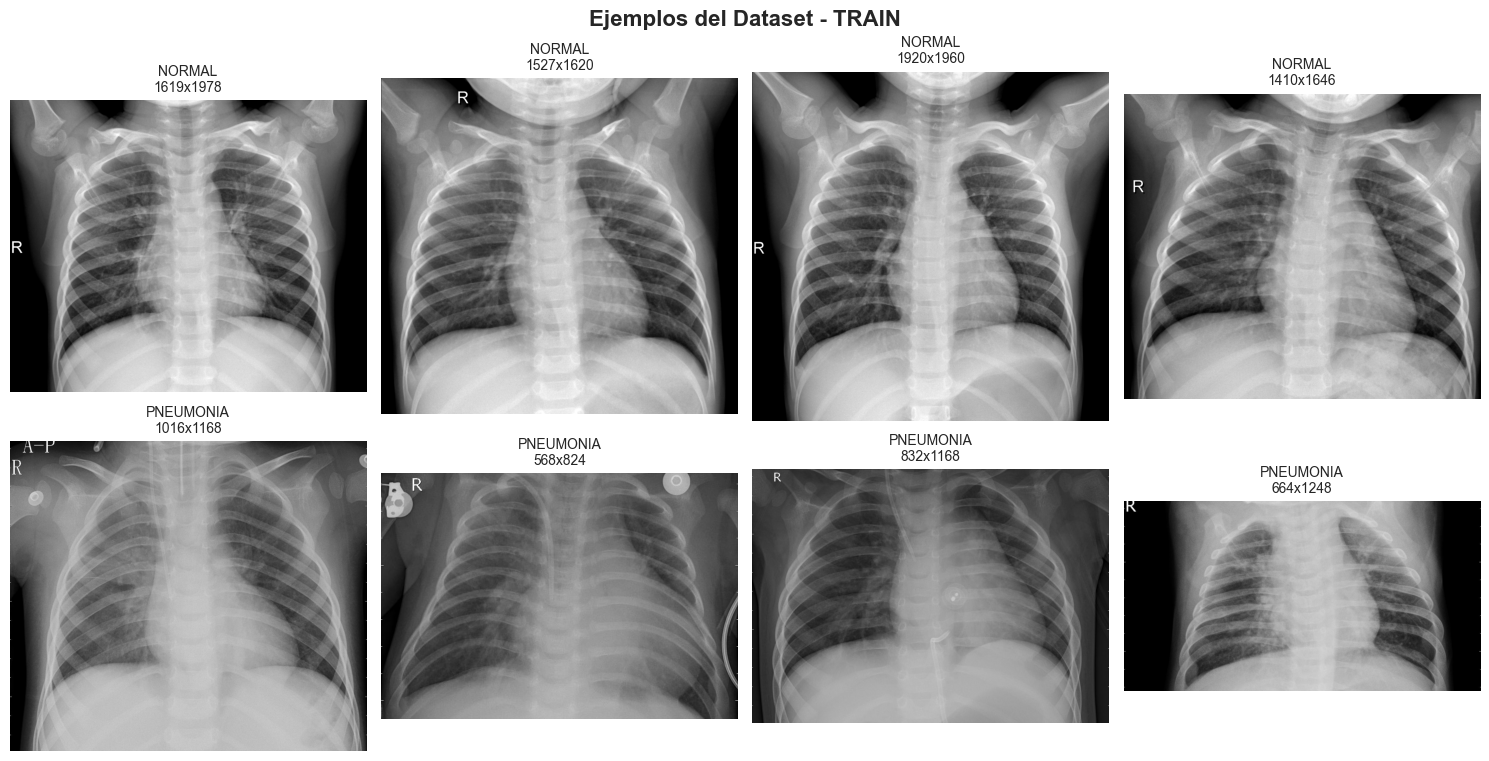

In [16]:
def display_sample_images(dataset_info, n_samples=4, split='train'):
    """Muestra ejemplos de cada clase del dataset."""
    if not dataset_info:
        print("No hay información del dataset")
        return
    
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
    fig.suptitle(f'Ejemplos del Dataset - {split.upper()}', fontsize=16, fontweight='bold')
    
    classes = ['NORMAL', 'PNEUMONIA']
    
    for row, class_name in enumerate(classes):
        images = dataset_info[split][class_name]
        
        if len(images) >= n_samples:
            sample_images = random.sample(images, n_samples)
        else:
            sample_images = images
        
        for col, img_path in enumerate(sample_images[:n_samples]):
            try:
                pil_img = Image.open(img_path)
                img_array = np.array(pil_img)
                
                if len(img_array.shape) == 3:
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
                
                ax = axes[row, col] if n_samples > 1 else axes[row]
                ax.imshow(img_array, cmap='gray')
                ax.set_title(f'{class_name}\n{img_array.shape[0]}x{img_array.shape[1]}', fontsize=10)
                ax.axis('off')
                
            except Exception as e:
                print(f"Error cargando {img_path}: {e}")
                ax = axes[row, col] if n_samples > 1 else axes[row]
                ax.axis('off')
                ax.text(0.5, 0.5, 'Error\ncargando\nimagen', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=8, color='red')
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / f'dataset_samples_{split}.png', dpi=300, bbox_inches='tight')
    plt.show()

if dataset_info:
    display_sample_images(dataset_info, n_samples=4, split='train')

vemos ejemplos reales de las dos clases del dataset. Las imágenes normales dela fila superior muestran pulmones que se ven claros, con las costillas mas visibles y sin áreas densas o manchas extrañas.

Las imágenes con neumonía de la fila inferior son notoriamente diferentes. Se ven más nubladas o con áreas mas blancas que pueden indicar inflamación o líquido en los pulmones.

Tambien podemos observar que las dimensiones de las imágenes varían bastante, desde 656x1000 hasta 1403x1662 pixels, lo que confirma que necesitamos el preprocesamiento para estandarizar los tamaños.



## 4. Análisis de Tamaños de Imagen

In [17]:
def analyze_image_sizes(dataset_info):
    """Analiza los tamaños de todas las imágenes en el dataset."""
    if not dataset_info:
        return None
    
    size_data = []
    
    for split in ['train', 'test', 'val']:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            images = dataset_info[split][class_name]
            
            print(f"Analizando {split}/{class_name}: {len(images)} imágenes")
            
            for img_path in tqdm(images, desc=f"Procesando {split}/{class_name}"):
                try:
                    pil_img = Image.open(img_path)
                    width, height = pil_img.size
                    
                    size_data.append({
                        'split': split,
                        'class': class_name,
                        'width': width,
                        'height': height,
                        'aspect_ratio': width / height
                    })
                    
                except Exception as e:
                    print(f"Error procesando {img_path}: {e}")
                    continue
    
    return pd.DataFrame(size_data)

df_sizes = analyze_image_sizes(dataset_info)

Analizando train/NORMAL: 1341 imágenes


Procesando train/NORMAL: 100%|██████████| 1341/1341 [00:04<00:00, 290.92it/s]


Analizando train/PNEUMONIA: 3875 imágenes


Procesando train/PNEUMONIA: 100%|██████████| 3875/3875 [00:16<00:00, 240.86it/s]


Analizando test/NORMAL: 234 imágenes


Procesando test/NORMAL: 100%|██████████| 234/234 [00:00<00:00, 360.24it/s]


Analizando test/PNEUMONIA: 390 imágenes


Procesando test/PNEUMONIA: 100%|██████████| 390/390 [00:00<00:00, 405.94it/s]


Analizando val/NORMAL: 8 imágenes


Procesando val/NORMAL: 100%|██████████| 8/8 [00:00<00:00, 536.96it/s]


Analizando val/PNEUMONIA: 8 imágenes


Procesando val/PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 946.26it/s]


Análisis completado con 5856 imágenes

ESTADÍSTICAS DE TAMAÑOS
                  width                                                   \
                  count         mean         std     min     25%     50%   
split class                                                                
test  NORMAL      234.0  1800.303419  365.930476   984.0  1533.0  1762.0   
      PNEUMONIA   390.0  1140.823077  208.858427   728.0   992.0  1111.0   
train NORMAL     1341.0  1667.734526  289.210512   912.0  1466.0  1640.0   
      PNEUMONIA  3875.0  1200.483613  291.305676   384.0  1000.0  1168.0   
val   NORMAL        8.0  1479.500000  221.727632  1240.0  1284.0  1446.0   
      PNEUMONIA     8.0  1217.000000  229.660619   968.0  1058.0  1172.0   

                                  height                                  \
                     75%     max   count         mean         std    min   
split class                                                                
test  NORMAL     2030.25

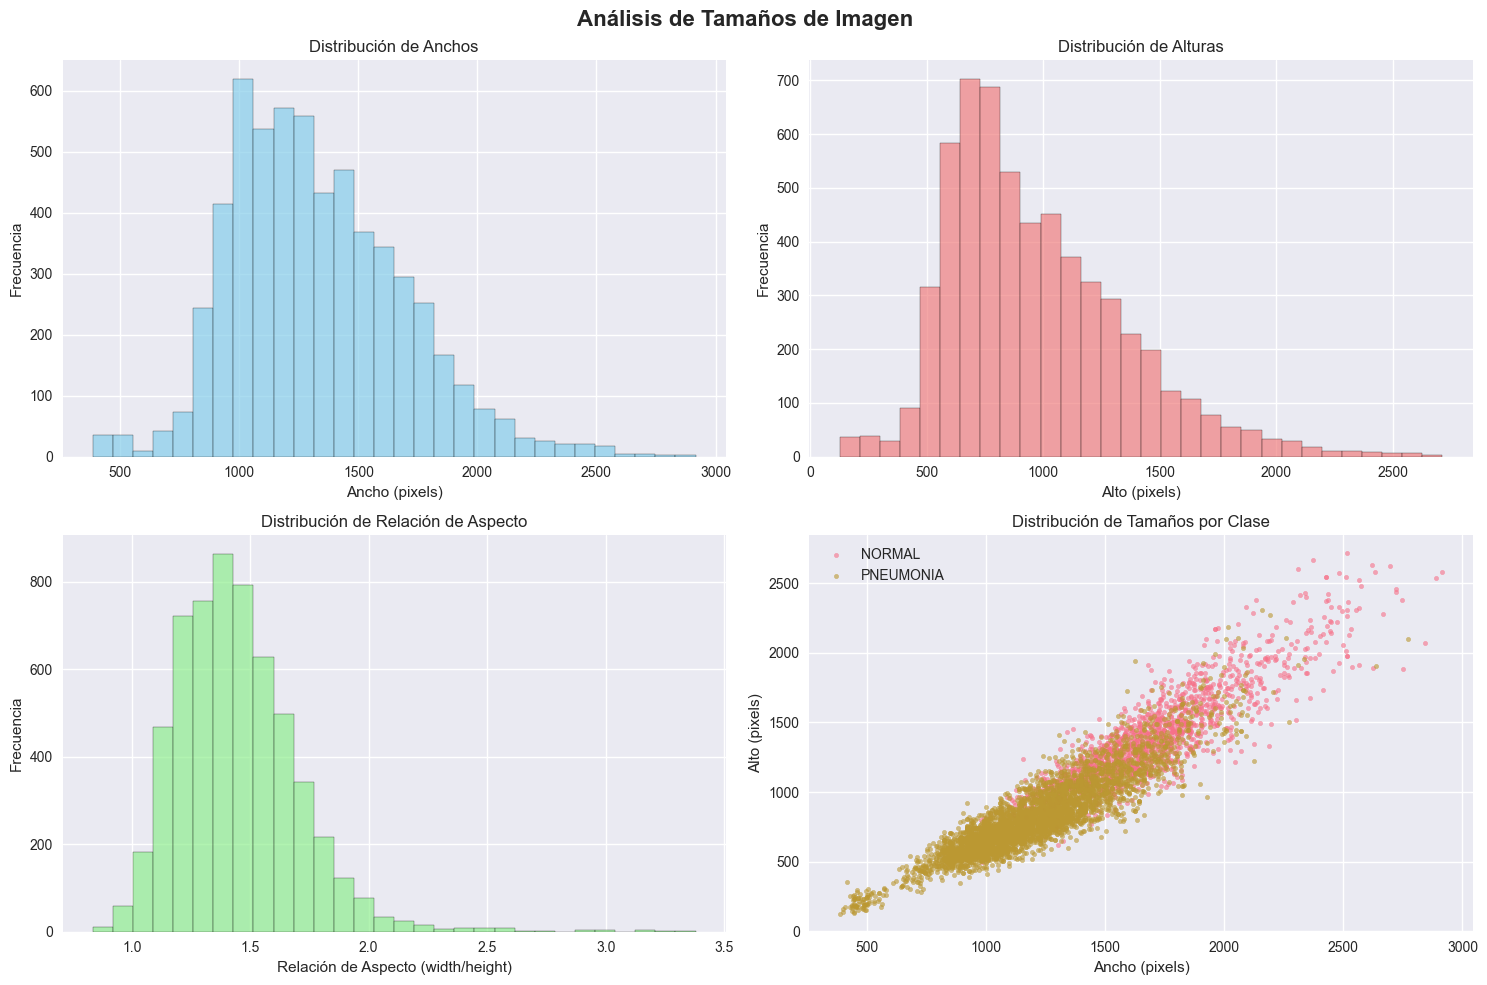


RESUMEN:
Ancho promedio: 1328 ± 364 pixels
Alto promedio: 971 ± 383 pixels
Relación de aspecto promedio: 1.44 ± 0.25
Rango de anchos: 384-2916
Rango de alturas: 127-2713


In [18]:
if df_sizes is not None and len(df_sizes) > 0:
    print(f"Análisis completado con {len(df_sizes)} imágenes")
    print("\nESTADÍSTICAS DE TAMAÑOS")
    print("=" * 50)
    
    # Estadísticas descriptivas
    size_stats = df_sizes.groupby(['split', 'class'])[['width', 'height']].describe()
    print(size_stats)
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análisis de Tamaños de Imagen', fontsize=16, fontweight='bold')
    
    # Distribución de anchos
    axes[0,0].hist(df_sizes['width'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribución de Anchos')
    axes[0,0].set_xlabel('Ancho (pixels)')
    axes[0,0].set_ylabel('Frecuencia')
    
    # Distribución de alturas
    axes[0,1].hist(df_sizes['height'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,1].set_title('Distribución de Alturas')
    axes[0,1].set_xlabel('Alto (pixels)')
    axes[0,1].set_ylabel('Frecuencia')
    
    # Relación de aspecto
    axes[1,0].hist(df_sizes['aspect_ratio'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,0].set_title('Distribución de Relación de Aspecto')
    axes[1,0].set_xlabel('Relación de Aspecto (width/height)')
    axes[1,0].set_ylabel('Frecuencia')
    
    # Scatter plot: ancho vs alto por clase
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_data = df_sizes[df_sizes['class'] == class_name]
        axes[1,1].scatter(class_data['width'], class_data['height'], 
                         alpha=0.6, label=class_name, s=10)
    
    axes[1,1].set_title('Distribución de Tamaños por Clase')
    axes[1,1].set_xlabel('Ancho (pixels)')
    axes[1,1].set_ylabel('Alto (pixels)')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'image_size_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Resumen estadístico
    print(f"\nRESUMEN:")
    print(f"Ancho promedio: {df_sizes['width'].mean():.0f} ± {df_sizes['width'].std():.0f} pixels")
    print(f"Alto promedio: {df_sizes['height'].mean():.0f} ± {df_sizes['height'].std():.0f} pixels")
    print(f"Relación de aspecto promedio: {df_sizes['aspect_ratio'].mean():.2f} ± {df_sizes['aspect_ratio'].std():.2f}")
    print(f"Rango de anchos: {df_sizes['width'].min()}-{df_sizes['width'].max()}")
    print(f"Rango de alturas: {df_sizes['height'].min()}-{df_sizes['height'].max()}")
    
else:
    print("Error: No se pudo completar el análisis de tamaños.")

Hay una diferencia notable en los tamaños entre las imágenes normales y las de neumonía. Las radiografías normales tienden a ser más grandes con un ancho promedio de ~1800 vs ~1140 pixels en el test, mientras que las de neumonía son más pequeñas y compactas.

La relación de aspecto se concentra alrededor de 1.4, lo que significa que las imágenes son un poco más anchas que altas. La variabilidad es considerable, el ancho va desde 384 hasta 2916 pixels, lo que confirma que necesitamos estandarizar los tamaños en el preprocesamiento.

En el scatter plot se ve claramente que hay dos "nubes" de puntos distinguibles, lo que sugiere que el tamaño de imagen podría ser incluso una característica útil para la clasificación, además de las características visuales que extraigamos después.

## 5. Pipeline de Preprocesamiento

El pipeline incluye:
1. Redimensionamiento a tamaño estándar
2. Mejora de contraste con CLAHE
3. Normalización de intensidad

In [8]:
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Aplica el pipeline de preprocesamiento a una imagen.
    
    Args:
        img_path: Ruta de la imagen
        target_size: Tamaño objetivo (width, height)
    
    Returns:
        numpy.ndarray: Imagen procesada o None si hay error
    """
    try:
        # Cargar imagen
        pil_img = Image.open(img_path)
        if pil_img.mode != 'L':
            pil_img = pil_img.convert('L')
        
        # Redimensionar
        resized_pil = pil_img.resize(target_size, Image.Resampling.LANCZOS)
        resized_array = np.array(resized_pil, dtype=np.uint8)
        
        # Aplicar CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        clahe_array = clahe.apply(resized_array)
        
        # Normalizar
        normalized_array = clahe_array.astype(np.float32) / 255.0
        
        return normalized_array
        
    except Exception as e:
        print(f"Error procesando {img_path}: {e}")
        return None

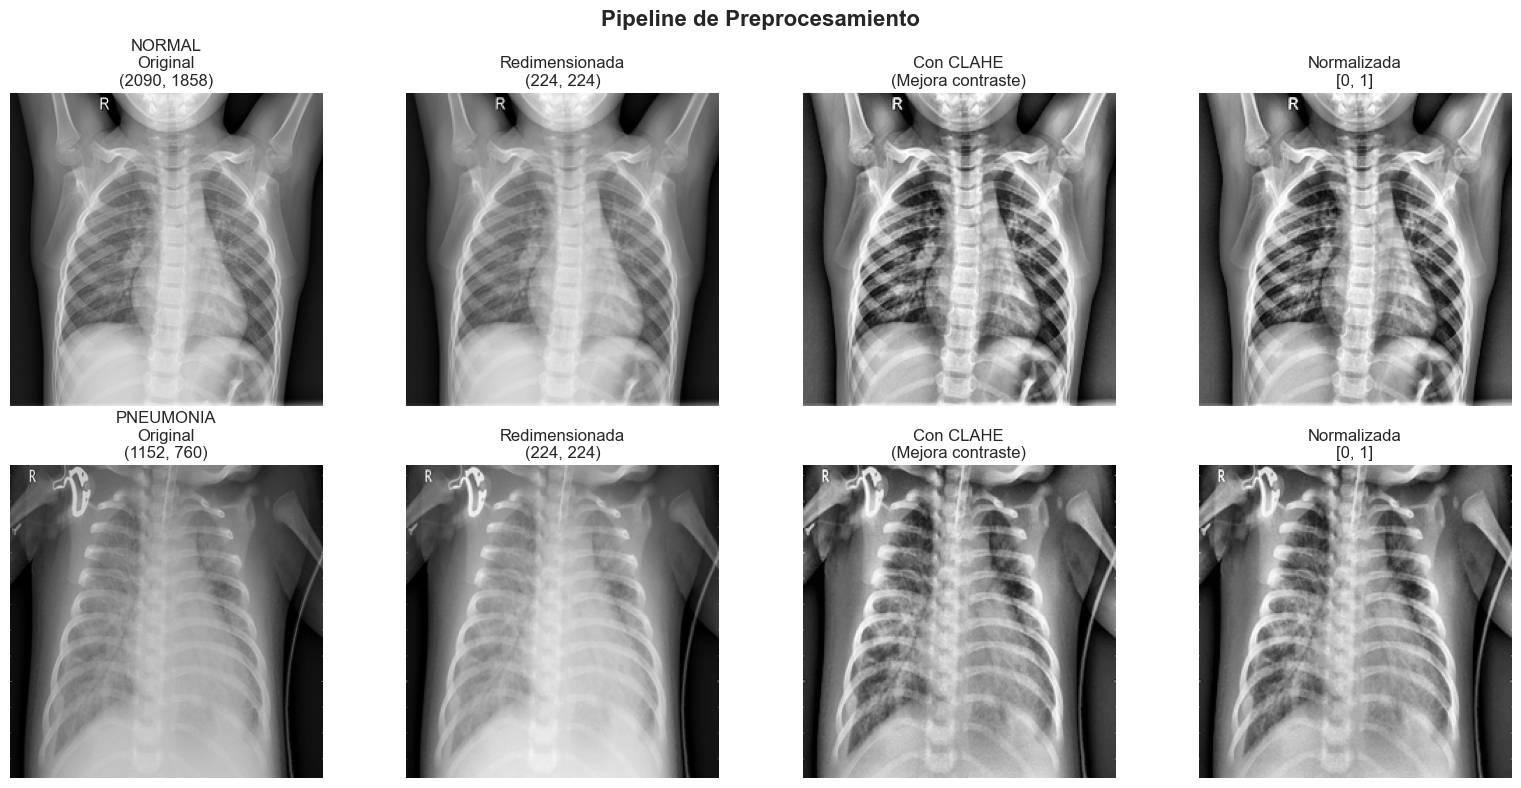

In [19]:
def demonstrate_preprocessing(dataset_info):
    """Demuestra el pipeline de preprocesamiento."""
    if not dataset_info:
        return
    
    # Seleccionar una imagen de cada clase
    normal_img = dataset_info['train']['NORMAL'][0]
    pneumonia_img = dataset_info['train']['PNEUMONIA'][0]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Pipeline de Preprocesamiento', fontsize=16, fontweight='bold')
    
    for row, (class_name, img_path) in enumerate([('NORMAL', normal_img), ('PNEUMONIA', pneumonia_img)]):
        try:
            # Cargar imagen original
            pil_img = Image.open(img_path)
            if pil_img.mode != 'L':
                pil_img = pil_img.convert('L')
            
            # 1. Original (redimensionada para visualización)
            original_resized = pil_img.resize((300, 300), Image.Resampling.LANCZOS)
            original_array = np.array(original_resized)
            
            axes[row, 0].imshow(original_array, cmap='gray')
            axes[row, 0].set_title(f'{class_name}\nOriginal\n{pil_img.size}')
            axes[row, 0].axis('off')
            
            # 2. Redimensionada
            resized_pil = pil_img.resize(IMG_SIZE, Image.Resampling.LANCZOS)
            resized_array = np.array(resized_pil, dtype=np.uint8)
            
            axes[row, 1].imshow(resized_array, cmap='gray')
            axes[row, 1].set_title(f'Redimensionada\n{IMG_SIZE}')
            axes[row, 1].axis('off')
            
            # 3. CLAHE
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            clahe_array = clahe.apply(resized_array)
            
            axes[row, 2].imshow(clahe_array, cmap='gray')
            axes[row, 2].set_title('Con CLAHE\n(Mejora contraste)')
            axes[row, 2].axis('off')
            
            # 4. Normalizada
            normalized_array = clahe_array.astype(np.float32) / 255.0
            
            axes[row, 3].imshow(normalized_array, cmap='gray')
            axes[row, 3].set_title('Normalizada\n[0, 1]')
            axes[row, 3].axis('off')
            
        except Exception as e:
            print(f"Error procesando {class_name}: {e}")
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'preprocessing_demo.png', dpi=300, bbox_inches='tight')
    plt.show()

if dataset_info:
    demonstrate_preprocessing(dataset_info)

En la primera columna tenemos las imágenes originales con sus tamaños reales (2090x1858 para normal y 1152x760 para neumonía) muy diferentes entre sí.

Después del redimensionamiento, ambas quedan en 224x224 pixels, que es el tamaño estándar que van a usar todos los algoritmos.

El CLAHE en la tercera columna mejora claramente el contraste. Se ven mucho más definidas las costillas, los pulmones y las diferencias entre tejidos. Es especialmente notorio en la imagen de neumonía donde ahora se distinguen mejor las áreas afectadas.

La normalización convierte todos los valores de intensidad al rango [0,1], lo cual es crucial para que los algoritmos de machine learning funcionen correctamente.


In [21]:
# Guardar configuración para siguientes notebooks
config = {
    'PROJECT_ROOT': str(PROJECT_ROOT),
    'DATA_PATH': str(DATA_PATH),
    'PROCESSED_DATA_PATH': str(PROCESSED_DATA_PATH),
    'RESULTS_PATH': str(RESULTS_PATH),
    'IMG_SIZE': IMG_SIZE,
    'RANDOM_SEED': RANDOM_SEED
}

with open(PROJECT_ROOT / 'config.pkl', 'wb') as f:
    pickle.dump(config, f)
